# **Identify Stop Signs with Transfer Learning**

In this project, we mainly want to demonstrate the possibility of using different architectures for transfer learning tasks. Therefore, the predictions made by some of the pre-trained CNN architectures demonstrated were not very accurate.

For better performance of each, it is suggested to apply fine-tuning by adding more custom layers on top of the base model to allow the latter layers to learn more information from the data they are trained on or fine-tuned on.



----


### Importing Required Libraries


In [2]:
import numpy as np
import datetime
import os
import random, shutil
import glob
import skillsnetwork

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from matplotlib.image import imread

from os import makedirs,listdir
from shutil import copyfile
from random import seed
from random import random
import keras 
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from sklearn import metrics

import opendatasets as od

sns.set_context('notebook')
sns.set_style('white')

2.13.0


### **Transfer Learning**


Transfer learning involves a technique where we take a pre-trained network, like a neural network for understanding data, and we use its initial layers as they are. Then, we adjust and train the later layers of the network using our own set of data that's specific to a certain task. This way, we can use the knowledge already stored in the network to help us with a similar task.

Here's a common transfer learning process using Keras:

1. **Start with a Base Model:**

Begin by setting up a base model and loading pre-trained weights, often from a source like ImageNet.

2. **Lock Some Layers:**

Make certain layers in the base model inactive by setting training = False. This is called "freezing" the layers.

3. **Create a New Model:**

Design a new model that builds on the outputs of the base model's layers. This new model will be suited for your specific task.

4. **Train the New Model:**

Train the model you've created using your own dataset. This process fine-tunes the model for the task you're targeting.


## Dataset

The stop sign datasets will be downloaded using the following cells. Compared to a typical dataset of images, the stop sign dataset is relatively small as it only contains around 200 training images and 8 test images. This is when transfer learning should come to rescue, because training models from scratch would require a lot of data, otherwise you will likely overfit your model.


#### Displaying raw images

Use the following code to display the first 5 images in the train set that have stop signs and the first 5 images that don't have stop signs.


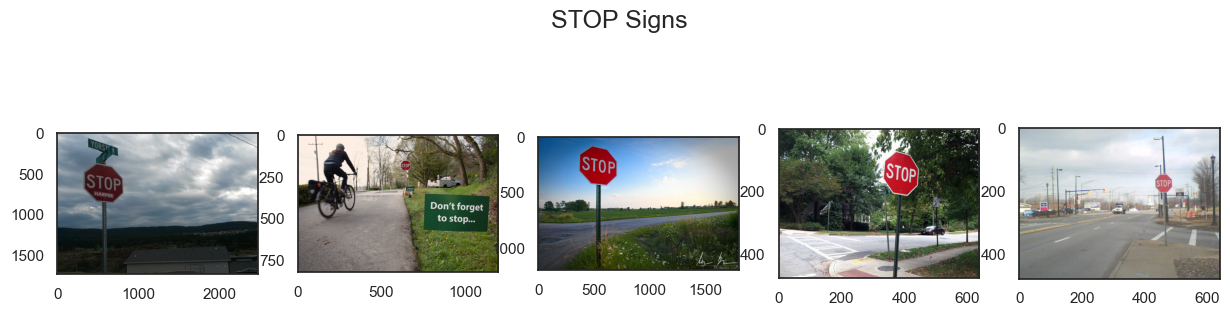

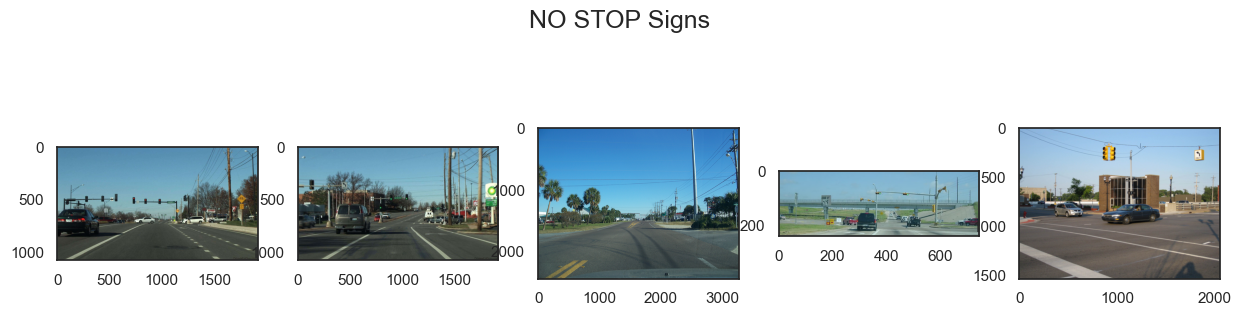

In [3]:
train_stop = glob.glob('./signs/train/stop/*')
train_not_stop = glob.glob('./signs/train/not_stop/*')

fig1, ax1 = plt.subplots(1,5,figsize=(15,4))
fig1.suptitle("STOP Signs", fontsize=18)
l1 = [ax1[i].imshow(imread(train_stop[i])) for i in range(5)]

fig2, ax2 = plt.subplots(1,5,figsize=(15,4))
fig2.suptitle("NO STOP Signs", fontsize=18)
l2 = [ax2[i].imshow(imread(train_not_stop[i])) for i in range(5)]


#### Building image data generators

We will build image data generators that perform real-time image augmentation while returning batches of image data. We will apply image augmentation on the training data only. We use a validation split of 0.2 and a batch size of 30.


In [4]:
path = "signs/train/"
labels = ['stop', 'not_stop']
seed = 123
batch_size = 30
target_size = (160, 160)

In [5]:
train_datagen = ImageDataGenerator(validation_split=0.2,
                                  rescale=1./255.,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

val_datagen = ImageDataGenerator(validation_split=0.2,
                                  rescale=1./255.)


In [6]:
train_generator = train_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=target_size,
    subset = 'training'
)

val_generator = val_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=target_size,
    subset = 'validation'
)

Found 152 images belonging to 2 classes.
Found 37 images belonging to 2 classes.


In [7]:
print(train_generator.class_indices)

prob2class = lambda x: 'Stop' if x < 0.5 else 'Not Stop' 

{'stop': 0, 'not_stop': 1}


For our test images, we convert them into numpy arrays with pixel values scaled to 0-1. The test data will not be seen by the model during training or validation, but they will be used to evaluate the predictive power of our model at the end.


In [8]:
from sklearn.utils import shuffle

test_files = glob.glob('signs/test/stop/*.jpeg') + glob.glob('signs/test/not_stop/*.jpeg')
test_files = shuffle(test_files)

test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=target_size)) for img in test_files]
test_imgs = np.array(test_imgs).astype('int')

# Standardize
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

### Defining a helper function for building, compiling, and fitting CNNs


In [9]:
def build_compile_fit(basemodel):
    
    # flatten the output of the base model
    x = Flatten()(basemodel.output)
    # add a fully connected layer 
    x = Dense(1024, activation='relu')(x)
    # add dropout layer for regularization
    x = Dropout(0.2)(x)
    # add final layer for classification
    x = Dense(1, activation='sigmoid')(x)

    model = Model(basemodel.input, x)
    model.compile(optimizer = optimizers.RMSprop(learning_rate=0.0001),
                                                       loss='binary_crossentropy',
                                                       metrics=['accuracy'])
    callbacks = [EarlyStopping(monitor = 'loss', 
                    patience = 5, 
                    mode = 'min', 
                    min_delta=0.01)]

    model.fit(train_generator,
              validation_data = val_generator,
              steps_per_epoch=5, # num of batches in one epoch
              epochs=10,
              callbacks=callbacks)
    
    return model

### Pre-trained Model 1: Inception-v3


**Inception-v3** is a successor to Inception-v1 with 24 million parameters and ran 48 layers deep.

Instead of focusing on increasing the depth of the network, InceptionNet focuses on increasing the width and depth of the model simultaneously to attain better accuracy, while keeping the computing resources constant.

It focuses on **parallel processing** and extraction of various feature maps concurrently using **Inception modules**, which are collections of convolutions with different filter sizes and pooling operations.



Let's import the pre-trained Inception-v3 architecture from keras applications for our transfer learning task:


In [10]:
from keras.applications.inception_v3 import InceptionV3

# initialize the base model
basemodel = InceptionV3(input_shape=(160, 160,3),
                          include_top = False,
                          weights = 'imagenet')

for layer in basemodel.layers:
    layer.trainable = False

# call the build_compile_fit function to complete model training
inception_v3 = build_compile_fit(basemodel)

87910968/87910968 [==============================] - 58s 1us/step
Epoch 1/10
5/5 [==============================] - 28s 4s/step - loss: 9.3876 - accuracy: 0.5164 - val_loss: 1.4057 - val_accuracy: 0.6757
Epoch 2/10
5/5 [==============================] - 15s 4s/step - loss: 1.8378 - accuracy: 0.5820 - val_loss: 2.1814 - val_accuracy: 0.4865
Epoch 3/10
5/5 [==============================] - 15s 3s/step - loss: 0.9918 - accuracy: 0.6885 - val_loss: 0.6041 - val_accuracy: 0.8108
Epoch 4/10
5/5 [==============================] - 16s 4s/step - loss: 0.8556 - accuracy: 0.7131 - val_loss: 0.5855 - val_accuracy: 0.8108
Epoch 5/10
5/5 [==============================] - 16s 3s/step - loss: 0.7206 - accuracy: 0.7049 - val_loss: 0.4301 - val_accuracy: 0.7838
Epoch 6/10
5/5 [==============================] - 15s 3s/step - loss: 0.6162 - accuracy: 0.8033 - val_loss: 0.3635 - val_accuracy: 0.8649
Epoch 7/10
5/5 [==============================] - 15s 3s/step - loss: 0.7401 - accuracy: 0.7705 - val_loss

The pre-trained part of our **inception_v3** model utilizes the weights obtained from the imagenet dataset training. Only the layers that we added are trained on the stop signs data.


Let's now display the test images along with their class labels predicted by the fitted **inception_v3**:


1/1 [==============================] - 0s 90ms/step


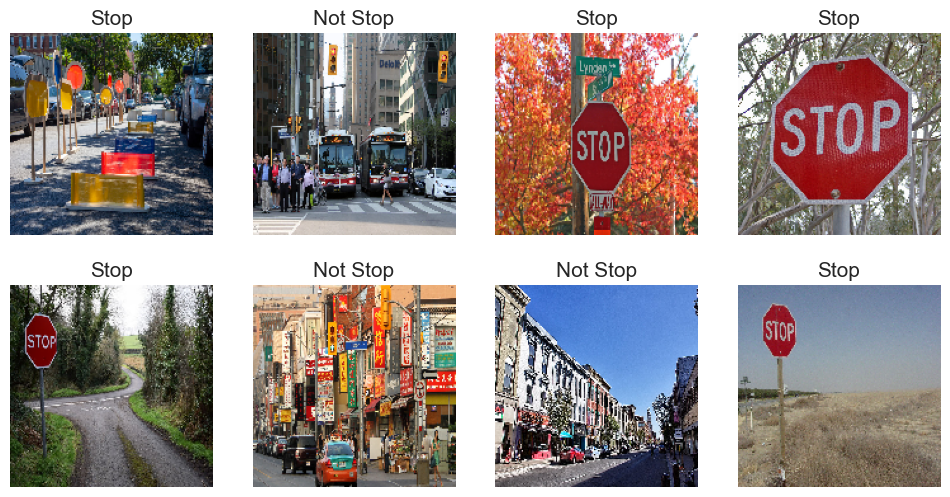

In [11]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, ax in enumerate(ax.flat):
    ax.imshow(test_imgs[i])
    pred_class = prob2class(inception_v3.predict(test_imgs_scaled[i].reshape(1, 160, 160,3)))
    
    # print the predicted class label as the title of the image
    ax.set_title(pred_class, fontsize=15)
    ax.axis("off")

### Pre-trained Model 2: MobileNet


**MobileNets** are very efficient and small deep learning architectures specially designed for mobile devices.

It makes use of a new kind of convolution layer, known as **Depthwise Separable convolution**. The main difference between a 2D convolution and a Depthwise convolution is that, the former is performed over multiple input channels by doing weighted sum of the input pixels with the filter, whereas the latter is performed separately over each channel.

For example, if the input image has three channels then the output of depthwise separable convolution will also have three channels. The next step is **Pointwise convolution**, which is similar to a regular convolution with a $1\times1$ filter. By doing so, we can again merge the three channels from depthwise separable convolution into one to creare new features.


Let's import the pre-trained MobileNet architecture from keras applications for our transfer learning task:


In [12]:
from keras.applications.mobilenet import MobileNet

# initialize the base model
basemodel = MobileNet(input_shape=(160, 160,3),
                          include_top = False,
                          weights = 'imagenet')

for layer in basemodel.layers:
    layer.trainable = False
    
# call the build_compile_fit function to complete model training
mobile_net = build_compile_fit(basemodel)

17225924/17225924 [==============================] - 10s 1us/step
Epoch 1/10
5/5 [==============================] - 19s 4s/step - loss: 7.6549 - accuracy: 0.6148 - val_loss: 0.8554 - val_accuracy: 0.6757
Epoch 2/10
5/5 [==============================] - 13s 2s/step - loss: 0.7764 - accuracy: 0.7787 - val_loss: 0.1286 - val_accuracy: 0.9459
Epoch 3/10
5/5 [==============================] - 16s 3s/step - loss: 0.4342 - accuracy: 0.8333 - val_loss: 0.3899 - val_accuracy: 0.8649
Epoch 4/10
5/5 [==============================] - 15s 3s/step - loss: 0.3496 - accuracy: 0.8361 - val_loss: 0.9939 - val_accuracy: 0.6757
Epoch 5/10
5/5 [==============================] - 13s 3s/step - loss: 0.7285 - accuracy: 0.8033 - val_loss: 0.2968 - val_accuracy: 0.8919
Epoch 6/10
5/5 [==============================] - 16s 3s/step - loss: 0.2744 - accuracy: 0.8934 - val_loss: 0.4194 - val_accuracy: 0.7838
Epoch 7/10
5/5 [==============================] - 14s 3s/step - loss: 0.2626 - accuracy: 0.9098 - val_loss

Let's display the test images along with the their class labels predicted by the fitted **mobile_net**:


1/1 [==============================] - 0s 79ms/step


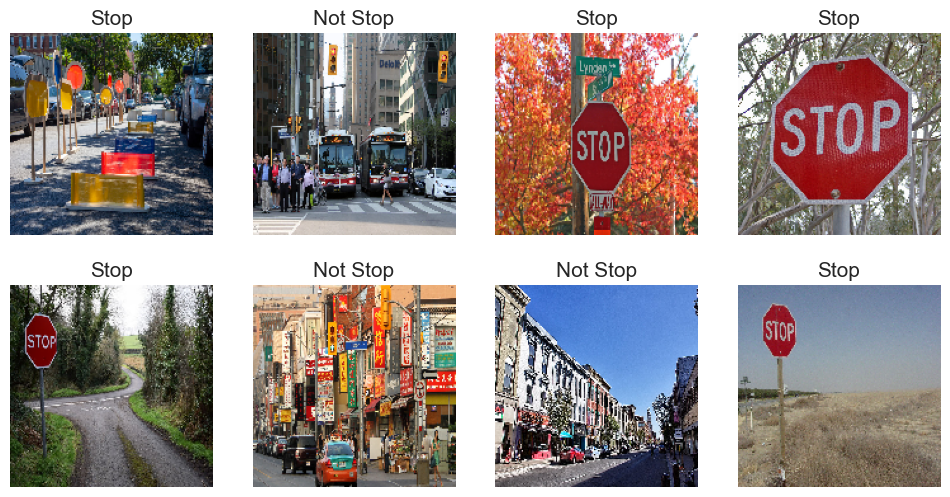

In [13]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, ax in enumerate(ax.flat):
    ax.imshow(test_imgs[i])
    pred_class = prob2class(mobile_net.predict(test_imgs_scaled[i].reshape(1, 160, 160,3)))
    
    # print the predicted class label as the title of the image
    ax.set_title(pred_class, fontsize=15)
    ax.axis("off")

### Pre-trained Model 3: ResNet-50


**ResNet** features special skip connections which add the output from an earlier layer directly to a later layer and a heavy use of batch normalization. It allows us to design deep CNNs without compromising the model’s convergence and accuracy. The basic building blocks for ResNets is the convolution and identity blocks.


Similarly, let's import the pre-trained ResNet-50 architecture from keras applications.


In [14]:
from keras.applications import ResNet50

# initialize the base model
basemodel = ResNet50(input_shape=(160, 160,3),
                          include_top = False,
                          weights = 'imagenet')

for layer in basemodel.layers:
    layer.trainable = False

# call the build_compile_fit function to complete model training
resnet_50 = build_compile_fit(basemodel)

94765736/94765736 [==============================] - 56s 1us/step
Epoch 1/10
5/5 [==============================] - 32s 6s/step - loss: 2.7100 - accuracy: 0.4590 - val_loss: 0.8598 - val_accuracy: 0.4865
Epoch 2/10
5/5 [==============================] - 23s 5s/step - loss: 0.9697 - accuracy: 0.4672 - val_loss: 0.8524 - val_accuracy: 0.5135
Epoch 3/10
5/5 [==============================] - 22s 4s/step - loss: 0.8831 - accuracy: 0.5574 - val_loss: 0.8036 - val_accuracy: 0.4865
Epoch 4/10
5/5 [==============================] - 22s 4s/step - loss: 0.8787 - accuracy: 0.5246 - val_loss: 0.8272 - val_accuracy: 0.4865
Epoch 5/10
5/5 [==============================] - 23s 5s/step - loss: 0.9328 - accuracy: 0.4672 - val_loss: 0.7264 - val_accuracy: 0.5405
Epoch 6/10
5/5 [==============================] - 22s 4s/step - loss: 1.1869 - accuracy: 0.3934 - val_loss: 0.7737 - val_accuracy: 0.4595
Epoch 7/10
5/5 [==============================] - 23s 4s/step - loss: 0.6978 - accuracy: 0.5492 - val_loss

Let's display the test images along with their class labels predicted by **resnet\_50**:


1/1 [==============================] - 0s 180ms/step


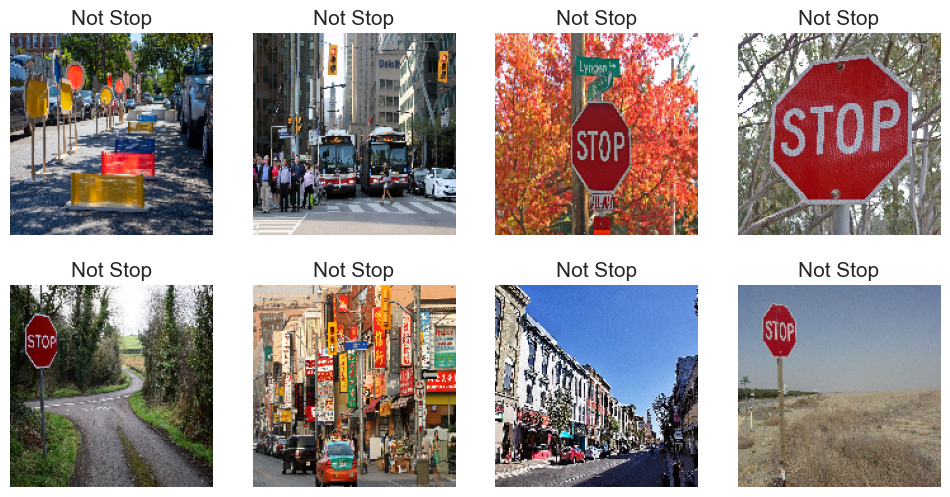

In [15]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, ax in enumerate(ax.flat):
    ax.imshow(test_imgs[i])
    pred_class = prob2class(resnet_50.predict(test_imgs_scaled[i].reshape(1, 160, 160,3)))
    
    # print the predicted class label as the title of the image
    ax.set_title(pred_class, fontsize=15)
    ax.axis("off")

## Custom image: Is it a stop sign?


'Not Stop'

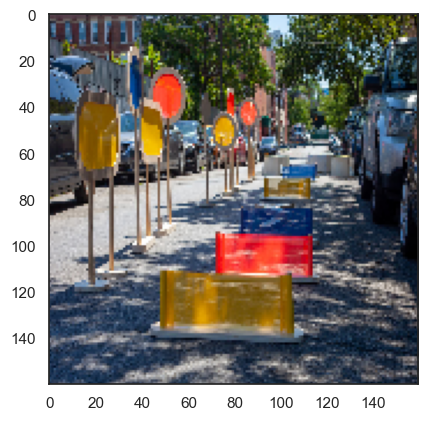

In [16]:
# Load the original image and resize it to IMG_DIM
IMG_DIM = (160,160)
orig_im = tf.keras.preprocessing.image.load_img("signs/test/not_stop/not_stop_3.jpeg", target_size=IMG_DIM)
plt.imshow(orig_im)

# Convert to array and rescale the image values
custom_im = tf.keras.preprocessing.image.img_to_array(orig_im)
custom_im_scaled = custom_im.astype('float32')
custom_im_scaled /= 255

# Predict the waste category
prob2class(resnet_50.predict(custom_im_scaled.reshape((1,
                                                       IMG_DIM[0],
                                                       IMG_DIM[1],
                                                       3)), verbose=0))